In [1]:
# !pip install pyspatialml
!pip install rasterio

In [1]:
from pyspatialml import Raster
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
os.chdir('/content/drive/MyDrive/MC_NEW-20221123T154430Z-001/MC_NEW/ML_GROUP-20230119T153151Z-001/ML_GROUP')
os.listdir()

['LULC.tfw',
 'LULC.tif.ovr',
 'LULC.tif',
 'LULC.tif.vat.cpg',
 'LULC.tif.aux.xml',
 'LULC.tif.vat.dbf',
 'geo.tif.vat.dbf',
 'geo.tif',
 'geo.tif.vat.cpg',
 'geo.tif.ovr',
 'geo.tfw',
 'geo.tif.aux.xml',
 'litho.tif.vat.cpg',
 'litho.tfw',
 'litho.tif.vat.dbf',
 'litho.tif.aux.xml',
 'litho.tif',
 'litho.tif.ovr',
 'aspect.tfw',
 'aspect.tif.ovr',
 'aspect.tif.aux.xml',
 'aspect.tif',
 'slope.tfw',
 'slope.tif.ovr',
 'slope.tif',
 'slope.tif.aux.xml',
 'road.tfw',
 'road.tif.aux.xml',
 'road.tif.ovr',
 'road.tif',
 'twi.tfw',
 'twi.tif',
 'twi.tif.aux.xml',
 'twi.tif.ovr',
 'DD.tfw',
 'DD.tif.aux.xml',
 'DD.tif.ovr',
 'DD.tif',
 'LD.tfw',
 'LD.tif.aux.xml',
 'LD.tif',
 'LD.tif.ovr',
 'ndvi_T.tfw',
 'ndvi_T.tif.ovr',
 'ndvi_T.tif',
 'ndvi_T.tif.aux.xml']

In [3]:
predictors = ['geo.tif', 'road.tif', 'litho.tif', 'LD.tif', 'ndvi_T.tif', 'twi.tif', 'LULC.tif', 'slope.tif', 'aspect.tif', 'DD.tif']

In [4]:
stack = Raster(predictors)
stack.count

10

In [5]:
vf = gpd.read_file('/content/drive/MyDrive/MC_NEW-20221123T154430Z-001/MC_NEW/training/training.shp')
vf_points = vf.centroid
vf.head(2)

,Id,geometry
0,1,"POLYGON Z ((243347.149 3388732.622 0.000, 2433..."
1,1,"POLYGON Z ((243306.724 3388876.132 0.000, 2432..."


In [6]:
df = stack.extract_vector(vf_points)
df.head(2)

,,geo,road,litho,LD,ndvi_T,twi,LULC,slope,aspect,DD,geometry
pixel_idx,geometry_idx,,,,,,,,,,,
0,0,2.0,0.0,6.0,0.080195,0.289495,4.511374,5.0,39.480736,280.491486,1.919997,POINT (243415.688 3388815.168)
1,1,2.0,0.0,6.0,0.080195,0.824188,2.323761,5.0,50.747879,247.416153,1.907240,POINT (243401.535 3388968.361)


In [7]:
df_points = df.merge(
    right=vf.loc[:, ["Id"]],
    left_on="geometry_idx",
    right_on="index",
    right_index=True
)

In [8]:
df_points.head()

,,geo,road,litho,LD,ndvi_T,twi,LULC,slope,aspect,DD,geometry,Id
pixel_idx,geometry_idx,,,,,,,,,,,,
0,0,2.0,0.000000,6.0,0.080195,0.289495,4.511374,5.0,39.480736,280.491486,1.919997,POINT (243415.688 3388815.168),1
1,1,2.0,0.000000,6.0,0.080195,0.824188,2.323761,5.0,50.747879,247.416153,1.907240,POINT (243401.535 3388968.361),1
2,2,2.0,0.000000,6.0,0.080195,0.863234,10.141537,5.0,35.780071,240.945389,1.894235,POINT (243331.416 3389101.021),1
3,3,2.0,0.000000,4.0,0.235854,0.346268,5.166389,7.0,38.113274,78.976547,1.836945,POINT (243785.521 3392278.366),1
4,4,2.0,288.133026,4.0,0.219220,0.769076,8.427302,7.0,42.328003,81.158188,1.830692,POINT (243752.100 3392170.022),1


In [9]:
# Prepare data for EDA
# "Id" is the target variable (0 = no landslide, 1 = landslide)
df_drop = df_points.drop(columns=['geometry','Id'])
df_drop.head()
df_drop.reset_index(drop=True)




,geo,road,litho,LD,ndvi_T,twi,LULC,slope,aspect,DD
0,2.0,0.000000,6.0,0.080195,0.289495,4.511374,5.0,39.480736,280.491486,1.919997
1,2.0,0.000000,6.0,0.080195,0.824188,2.323761,5.0,50.747879,247.416153,1.907240
2,2.0,0.000000,6.0,0.080195,0.863234,10.141537,5.0,35.780071,240.945389,1.894235
3,2.0,0.000000,4.0,0.235854,0.346268,5.166389,7.0,38.113274,78.976547,1.836945
4,2.0,288.133026,4.0,0.219220,0.769076,8.427302,7.0,42.328003,81.158188,1.830692
...,...,...,...,...,...,...,...,...,...,...
132,7.0,17915.294922,2.0,0.000000,-0.117570,5.367736,1.0,3.337111,210.963760,0.747359
133,5.0,19478.304688,1.0,0.139481,NaN,5.843851,6.0,28.516256,6.340192,0.152507
134,5.0,18449.515625,1.0,0.295252,-0.018452,6.339057,6.0,40.726139,2.663001,0.181959
135,6.0,0.000000,0.0,0.324770,0.680624,7.365918,1.0,1.811248,161.565048,1.624501


<function matplotlib.pyplot.show(close=None, block=None)>

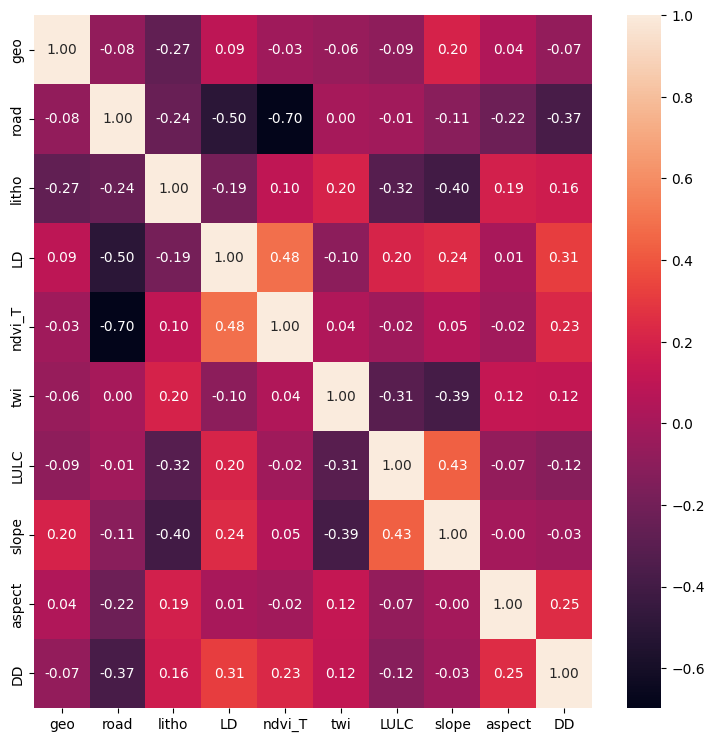

In [10]:

#correlation analysis between the landslide conditioning parameters
corr = df_drop.corr(method ='pearson')
import seaborn as sn

fig,ax = plt.subplots(figsize=(9,9))
ax = sn.heatmap(corr,fmt ='.2f',annot=True,cbar =True)

plt.show


In [11]:
data =  df_points.drop(columns=['geometry'])
data.isnull().sum()
data.dropna()
data.reset_index(drop=True)

,geo,road,litho,LD,ndvi_T,twi,LULC,slope,aspect,DD,Id
0,2.0,0.000000,6.0,0.080195,0.289495,4.511374,5.0,39.480736,280.491486,1.919997,1
1,2.0,0.000000,6.0,0.080195,0.824188,2.323761,5.0,50.747879,247.416153,1.907240,1
2,2.0,0.000000,6.0,0.080195,0.863234,10.141537,5.0,35.780071,240.945389,1.894235,1
3,2.0,0.000000,4.0,0.235854,0.346268,5.166389,7.0,38.113274,78.976547,1.836945,1
4,2.0,288.133026,4.0,0.219220,0.769076,8.427302,7.0,42.328003,81.158188,1.830692,1
...,...,...,...,...,...,...,...,...,...,...,...
132,7.0,17915.294922,2.0,0.000000,-0.117570,5.367736,1.0,3.337111,210.963760,0.747359,0
133,5.0,19478.304688,1.0,0.139481,NaN,5.843851,6.0,28.516256,6.340192,0.152507,0
134,5.0,18449.515625,1.0,0.295252,-0.018452,6.339057,6.0,40.726139,2.663001,0.181959,0
135,6.0,0.000000,0.0,0.324770,0.680624,7.365918,1.0,1.811248,161.565048,1.624501,0


In [14]:
mlfile = data.to_csv('/content/drive/MyDrive/MC_NEW-20221123T154430Z-001/lsdata.csv',index =False) #exporting to csv for ML analysis

In [15]:
df = pd.read_csv('/content/drive/MyDrive/MC_NEW-20221123T154430Z-001/lsdata.csv')

In [17]:
df.isnull().sum()
df_1 = df.dropna()
df_1 =df_1.reset_index(drop =True)

In [18]:
X = df_1.drop(columns=['Id'])
y = df_1['Id']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# XGBoost Hyperparameter Tuning with Grid Search
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 6, 9, 12],
    'n_estimators': [50, 100, 150, 200],
    'gamma': [0, 0.1, 1, 2],
    'lambda': [0, 0.5, 1, 2]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

xgb_grid_search.fit(X_train_scaled, y_train)

print('Best XGBoost Parameters:', xgb_grid_search.best_params_)
print('Best XGBoost AUC Score:', xgb_grid_search.best_score_)

# Evaluate on test set
xgb_best_model = xgb_grid_search.best_estimator_
y_pred_xgb = xgb_best_model.predict_proba(X_test_scaled)[:, 1]
xgb_test_auc = roc_auc_score(y_test, y_pred_xgb)
print('XGBoost Test AUC:', xgb_test_auc)

In [ ]:
# MLP Hyperparameter Tuning with Grid Search
mlp_param_grid = {
    'hidden_layer_sizes': [(32, 16), (64, 32), (128, 64), (64,)],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam', 'rmsprop'],
    'alpha': [0.0001, 0.001, 0.01]
}

mlp_model = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1, max_iter=200)
mlp_grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=mlp_param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

mlp_grid_search.fit(X_train_scaled, y_train)

print('Best MLP Parameters:', mlp_grid_search.best_params_)
print('Best MLP AUC Score:', mlp_grid_search.best_score_)

# Evaluate on test set
mlp_best_model = mlp_grid_search.best_estimator_
y_pred_mlp = mlp_best_model.predict_proba(X_test_scaled)[:, 1]
mlp_test_auc = roc_auc_score(y_test, y_pred_mlp)
print('MLP Test AUC:', mlp_test_auc)

In [ ]:
# Final Models with Selected Parameters
final_xgb_model = XGBClassifier(
    learning_rate=0.05,
    max_depth=6,
    n_estimators=150,
    gamma=1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

final_mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    learning_rate_init=0.001,
    activation='relu',
    solver='adam',
    alpha=0.001,
    early_stopping=True,
    validation_fraction=0.1,
    max_iter=200,
    random_state=42
)

# Train final models
final_xgb_model.fit(X_train_scaled, y_train)
final_mlp_model.fit(X_train_scaled, y_train)

# Evaluate final models
final_xgb_pred = final_xgb_model.predict_proba(X_test_scaled)[:, 1]
final_mlp_pred = final_mlp_model.predict_proba(X_test_scaled)[:, 1]

print('Final XGBoost Test AUC:', roc_auc_score(y_test, final_xgb_pred))
print('Final MLP Test AUC:', roc_auc_score(y_test, final_mlp_pred))
print('XGBoost Classification Report:\n', classification_report(y_test, final_xgb_model.predict(X_test_scaled)))
print('MLP Classification Report:\n', classification_report(y_test, final_mlp_model.predict(X_test_scaled)))

In [ ]:
# Predict on the entire raster stack
X_stack = stack.read()  # Read raster data into numpy array
n_samples, n_rows, n_cols = X_stack.shape[0], X_stack.shape[1], X_stack.shape[2]
X_stack_2d = X_stack.reshape(n_samples, -1).T  # Reshape to (pixels, features)

# Standardize the raster data
X_stack_scaled = scaler.transform(X_stack_2d)

# XGBoost predictions
xgb_pred_proba = final_xgb_model.predict_proba(X_stack_scaled)[:, 1]  # Probability of landslide
xgb_pred_2d = xgb_pred_proba.reshape(n_rows, n_cols)  # Reshape back to 2D

# MLP predictions
mlp_pred_proba = final_mlp_model.predict_proba(X_stack_scaled)[:, 1]  # Probability of landslide
mlp_pred_2d = mlp_pred_proba.reshape(n_rows, n_cols)  # Reshape back to 2D

# Create Raster objects for predictions
result_xgb = Raster(np.expand_dims(xgb_pred_2d, axis=0), crs=stack.crs, transform=stack.transform)
result_mlp = Raster(np.expand_dims(mlp_pred_2d, axis=0), crs=stack.crs, transform=stack.transform)

In [ ]:
# Save the prediction rasters
result_xgb.write('/content/drive/MyDrive/Useful for writing and knowledge papers/XGB_GANG_2023.tif', nodata=-9999)
result_mlp.write('/content/drive/MyDrive/Useful for writing and knowledge papers/MLP_GANG_2023.tif', nodata=-9999)

In [ ]:
# Visualize the prediction rasters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(xgb_pred_2d, cmap='viridis')
plt.title('XGBoost Landslide Susceptibility')
plt.colorbar(label='Probability')

plt.subplot(1, 2, 2)
plt.imshow(mlp_pred_2d, cmap='viridis')
plt.title('MLP Landslide Susceptibility')
plt.colorbar(label='Probability')
plt.show()

In [ ]:
!pip install shap
import shap

In [ ]:
# Create a SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(final_xgb_model)

In [ ]:
# Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train_scaled)

In [ ]:
# Generate SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, plot_type="bar")
plt.title("SHAP Summary Plot for XGBoost Model (Feature Importance)")
plt.tight_layout()
plt.show()

In [ ]:

# Optional: Detailed SHAP summary plot (violin plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)
plt.title("SHAP Summary Plot for XGBoost Model (Detailed)")
plt.tight_layout()
plt.show()